In [1]:
import pandas as pd

In [2]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

In [3]:
import pickle

In [4]:
import re

In [2]:
df = pd.read_csv("英国_商科_applicants.csv")

In [3]:
df.head()

,school,applicant
0,卡迪夫大学国际经济学、银行与金融理学硕士,"郑州航空工业管理学院, 经济学, 三年以上工作经验，GPA76.01，无"
1,格拉斯哥大学信息管理与保存理学硕士,"华东师范大学, 信息管理与信息系统, 已毕业，GPA81.52，无"
2,剑桥大学经济学哲学硕士,"中央财经大学, 国际经济与贸易（国际贸易/金融风险管理方向）, 大四，GPA91.72，雅思..."
3,伦敦大学国王学院金融学（资产定价）理学硕士,"中国海洋大学, 金融学, 大四，GPA97.93，无"
4,南安普顿大学会计与管理理学硕士,"湖南农业大学, 金融学, 大四，GPA81.2，暂无"


In [21]:
df['applicant_school'] = df['applicant'].apply(lambda x: x.split(',')[0].strip())

In [7]:
chinese_schools = pd.read_csv("../data/chinese_universities.csv",header=None)

In [8]:
chinese_schools.columns=['id', 'school_name', 'school_id', 'relation', 'location', 'type', 'note']

In [9]:
def match_school(school):
    if school in list(chinese_schools['school_name'].unique()):
        return 1
    for s in list(chinese_schools['school_name'].unique()):
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [224]:
with open('../data/chinese_schools.pickle', 'wb') as f:
    pickle.dump(list(chinese_schools['school_name'].unique()), f)


In [34]:
df['is_chinese_undergrad'] = df['applicant_school'].apply(match_school)

In [10]:
with open('../data/211.pickle', 'rb') as f:
    school_211 = pickle.load(f)

In [11]:
with open('../data/985.pickle', 'rb') as f:
    school_985 = pickle.load(f)

In [225]:
from pathlib import Path

In [226]:
p = Path('.')
with open(p/'../data/211.pickle', 'rb') as f:
    school_211 = pickle.load(f)

with open(p/'../data/985.pickle', 'rb') as f:
    school_985 = pickle.load(f)

In [12]:
def is_school_985(school):
    if school in school_985:
        return 1
    for s in school_985:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [13]:
def is_school_211(school):
    if school in school_211:
        return 1
    for s in school_211:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [47]:
df['is_985'] = df['applicant_school'].apply(is_school_985)
df['is_211'] = df['applicant_school'].apply(is_school_211)

In [14]:
zhuanke_schools = chinese_schools[chinese_schools['type'] == '专科']['school_name'].to_list()

In [229]:
with open('../data/zhuanke_schools.pickle', 'wb') as f:
    pickle.dump(zhuanke_schools, f)


In [230]:
with open('../data/minban_schools.pickle', 'wb') as f:
    pickle.dump(minban_schools, f)


In [231]:
with open('../data/heban_schools.pickle', 'wb') as f:
    pickle.dump(heban_schools, f)

In [15]:
def is_school_zhuanke(school):
    if school in zhuanke_schools:
        return 1
    for s in zhuanke_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [165]:
df['is_zhuanke'] = df['applicant_school'].apply(is_school_zhuanke)

In [16]:
minban_schools = chinese_schools[chinese_schools['note'] == '民办']['school_name'].to_list()
heban_schools = chinese_schools[((chinese_schools['note'] == '中外合作办学') | (chinese_schools['note'] == '内地与港澳台地区合作办学'))]['school_name'].to_list()

In [17]:
def is_school_minban(school):
    if school in minban_schools:
        return 1
    for s in minban_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [18]:
def is_school_heban(school):
    if school in heban_schools:
        return 1
    for s in heban_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [171]:
df['is_minban'] = df['applicant_school'].apply(is_school_minban)
df['is_heban'] = df['applicant_school'].apply(is_school_heban)

In [19]:
qs_rankings = pd.read_csv('../data/qs_ranking_top_100.csv')

In [232]:
top_qs_100_schools = qs_rankings['ch_name'].to_list() + qs_rankings['en_name'].to_list()

In [234]:
with open('../data/top_qs_100_schools.pickle', 'wb') as f:
    pickle.dump(top_qs_100_schools, f)

In [20]:
def is_school_top_100_qs(school):
    top_qs_100_schools = qs_rankings['ch_name'].to_list() + qs_rankings['en_name'].to_list()
    for s in top_qs_100_schools:
        if fuzz.partial_ratio(school, s) >= 90:
            return 1
    return 0

In [103]:
df['is_top_100_qs'] = df['applicant_school'].apply(is_school_top_100_qs)

In [21]:
def extract_gpa(txt):
    ## I'm really bad at regular expression and i don't intend to optimize it.
    try:
        pattern = r"GPA\d+\.\d+"

        result = re.findall(pattern, txt)
        if not bool(result):
            pattern = r"GPA\d+"
            result = re.findall(pattern, txt)
        if not bool(result):
            pattern = r"GPA \d+"
            result = re.findall(pattern, txt)
        return result[0]
    except IndexError:
        return None

In [120]:
df['gpa'] = df['applicant'].apply(extract_gpa)

In [124]:
df['gpa'] = df['gpa'].apply(lambda x: x.replace('GPA', '').strip())

In [126]:
df['gpa'] = pd.to_numeric(df['gpa'])

In [22]:
def transform_gpa(gpa):
    if gpa <= 5:
        return (gpa + 1) * 20
    if gpa <= 20: # weird systems
        return None
    return gpa

In [143]:
df['gpa'] = df['gpa'].apply(transform_gpa)

In [23]:
major_all = pd.read_csv("../data/指南者专业信息全.csv")

In [24]:
major_all['qs_ranking'] = major_all['ranking'].apply(lambda x: int(x.split("：")[1].strip().replace("+", "")))

In [181]:
df = df.merge(major_all[['ch_name', 'qs_ranking']], left_on='school', right_on='ch_name', how='left')

In [185]:
df = df.drop(['ch_name'], axis=1)

In [25]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [216]:
_df = df[df['qs_ranking'].notna()]
_df = _df[_df['gpa'].notna()]

In [217]:
y = _df['qs_ranking']
x = _df[['is_chinese_undergrad', 'is_985', 'is_211', 'is_top_100_qs', 'gpa', 'is_zhuanke', 'is_minban', 'is_heban']]

In [223]:
model = GradientBoostingRegressor(n_estimators=10)

In [220]:
X_train, X_valid, y_train, y_valid = train_test_split(x, y, test_size=0.2, random_state=23)

In [224]:
model.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=10)

In [225]:
y_pred = model.predict(X_valid)

In [230]:
np.sqrt(mean_squared_error(y_pred, y_valid))

51.71751160566586

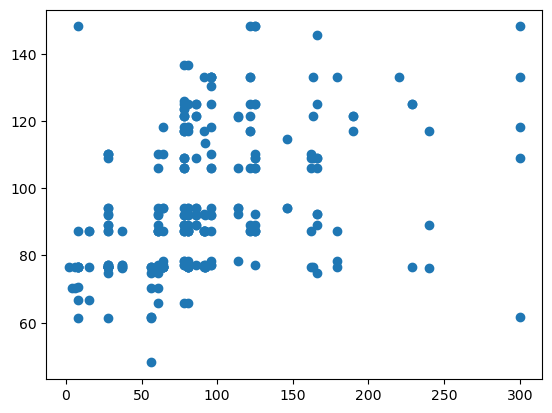

In [235]:
plt.scatter(y_valid, y_pred)

## Using k neartest neighbor instead

In [236]:
df.head()

,school,applicant,applicant_school,is_chinese_undergrad,is_985,is_211,is_top_100_qs,gpa,is_zhuanke,is_minban,is_heban,qs_ranking
0,卡迪夫大学国际经济学、银行与金融理学硕士,"郑州航空工业管理学院, 经济学, 三年以上工作经验，GPA76.01，无",郑州航空工业管理学院,1,0,0,0,76.01,0,0,0,166.0
1,格拉斯哥大学信息管理与保存理学硕士,"华东师范大学, 信息管理与信息系统, 已毕业，GPA81.52，无",华东师范大学,1,1,1,0,81.52,0,0,0,81.0
2,剑桥大学经济学哲学硕士,"中央财经大学, 国际经济与贸易（国际贸易/金融风险管理方向）, 大四，GPA91.72，雅思...",中央财经大学,1,0,1,0,91.72,0,0,0,2.0
3,伦敦大学国王学院金融学（资产定价）理学硕士,"中国海洋大学, 金融学, 大四，GPA97.93，无",中国海洋大学,1,1,1,0,97.93,0,0,0,37.0
4,南安普顿大学会计与管理理学硕士,"湖南农业大学, 金融学, 大四，GPA81.2，暂无",湖南农业大学,1,0,0,0,81.20,0,1,0,78.0


In [241]:
_df['gpa_normalized'] = (_df['gpa'] - _df['gpa'].mean()) / _df['gpa'].std()

In [26]:
from sklearn.neighbors import NearestNeighbors

In [27]:
model = NearestNeighbors()

In [243]:
train_data = _df[['is_chinese_undergrad', 'is_985', 'is_211', 'is_top_100_qs', 'is_zhuanke', 'is_minban', 'is_heban', 'gpa_normalized']]

In [242]:
model.fit(train_data)

NearestNeighbors()

In [265]:
model.kneighbors([train_data.iloc[100]], n_neighbors=10)

/Users/leilingtao/anaconda/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


(array([[0.        , 0.00461349, 0.00461349, 0.00461349, 0.00461349,
         0.0199918 , 0.03537011, 0.03537011, 0.06920239, 0.06920239]]),
 array([[100, 529, 550, 527, 560, 699, 682, 769, 766, 576]]))

In [260]:
_df.iloc[100]

school                                   南安普顿大学经济学理学硕士
applicant               北京工业大学, 经济统计学, 已毕业，GPA86.21，暂无
applicant_school                                北京工业大学
is_chinese_undergrad                                 1
is_985                                               1
is_211                                               1
is_top_100_qs                                        0
gpa                                              86.21
is_zhuanke                                           0
is_minban                                            1
is_heban                                             0
qs_ranking                                        78.0
gpa_normalized                                0.269103
Name: 100, dtype: object

In [266]:
_df.iloc[576]

school                               曼彻斯特大学国际时尚营销理学硕士
applicant               北京理工大学珠海学院, 商务英语, 大四，GPA86.66
applicant_school                           北京理工大学珠海学院
is_chinese_undergrad                                1
is_985                                              1
is_211                                              1
is_top_100_qs                                       0
gpa                                             86.66
is_zhuanke                                          0
is_minban                                           1
is_heban                                            0
qs_ranking                                       28.0
gpa_normalized                               0.338305
Name: 596, dtype: object

In [270]:
_df.iloc[[100, 529, 550, 527, 560, 699, 682, 769, 766, 576]]['qs_ranking']

100     78.0
546     64.0
568     92.0
544     64.0
579     61.0
739     37.0
716     81.0
816     64.0
811    162.0
596     28.0
Name: qs_ranking, dtype: float64

In [274]:
_df[_df['qs_ranking'] <= 40]['qs_ranking'].unique()

array([ 2., 37., 28., 15.,  8.,  6.,  4.])

## business logic

1. Find 12 nearest neighbor based on all dataset, get the list of available qs_rankings
2. Based on the 12 nearest neighbors, get the top 3, middle 6 and bottom 3 qs_rankings
3. Translate that into corresponding tiers (i.e. if avg of top 3 is 20, then find 10 - 30)
4. For each tier, find if there're corresponding schools/majors in the region
5. apply filter (language and tuition)
6. return the tiers

In [28]:
import os

In [33]:
all_applicant_df_fns = []
for fn in os.listdir('../data/'):
    if '_applicants.csv' in fn:
        all_applicant_df_fns.append(fn)

In [36]:
all_applicant_dfs = [pd.read_csv(f'../data/{t}') for t in all_applicant_df_fns]

In [37]:
for df_fn, df in zip(all_applicant_df_fns, all_applicant_dfs):
    df['fn'] = df_fn

In [38]:
all_applicant_dfs = pd.concat(all_applicant_dfs)

In [40]:
def process_applicant_df(df):
    df['gpa'] = df['applicant'].apply(extract_gpa)
    df['gpa'] = df['gpa'].apply(lambda x: x.replace('GPA', '').strip() if bool(x) else None)
    df['gpa'] = pd.to_numeric(df['gpa'])
    df['gpa'] = df['gpa'].apply(transform_gpa)
    df['gpa_normalized'] = (df['gpa'] - df['gpa'].mean()) / df['gpa'].std()
    df['applicant_school'] = df['applicant'].apply(lambda x: x.split(',')[0].strip())
    df['is_chinese_undergrad'] = df['applicant_school'].apply(match_school)
    df['is_985'] = df['applicant_school'].apply(is_school_985)
    df['is_211'] = df['applicant_school'].apply(is_school_211)
    df['is_zhuanke'] = df['applicant_school'].apply(is_school_zhuanke)
    df['is_minban'] = df['applicant_school'].apply(is_school_minban)
    df['is_heban'] = df['applicant_school'].apply(is_school_heban)
    df['is_top_100_qs'] = df['applicant_school'].apply(is_school_top_100_qs)
    df['school'] = df['school'].apply(lambda x: x.replace('offer一枚', ''))
    return df

In [237]:
all_applicant_dfs['gpa'].mean(), all_applicant_dfs['gpa'].std()

(84.942731615178, 6.208422970617356)

In [41]:
t = process_applicant_df(all_applicant_dfs)

In [42]:
t.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11980 entries, 0 to 979
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   school                11980 non-null  object 
 1   applicant             11980 non-null  object 
 2   fn                    11980 non-null  object 
 3   gpa                   11912 non-null  float64
 4   gpa_normalized        11912 non-null  float64
 5   applicant_school      11980 non-null  object 
 6   is_chinese_undergrad  11980 non-null  int64  
 7   is_985                11980 non-null  int64  
 8   is_211                11980 non-null  int64  
 9   is_zhuanke            11980 non-null  int64  
 10  is_minban             11980 non-null  int64  
 11  is_heban              11980 non-null  int64  
 12  is_top_100_qs         11980 non-null  int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 1.3+ MB


In [43]:
_t = t.merge(major_all[['ch_name', 'qs_ranking']], left_on='school', right_on='ch_name', how='left')

In [45]:
_t.to_csv("../data/all_applicant_training_data.csv", index=None)

## Training the KNN model

In [46]:
_t.columns

Index(['school', 'applicant', 'fn', 'gpa', 'gpa_normalized',
       'applicant_school', 'is_chinese_undergrad', 'is_985', 'is_211',
       'is_zhuanke', 'is_minban', 'is_heban', 'is_top_100_qs', 'ch_name',
       'qs_ranking'],
      dtype='object')

In [177]:
_t = _t[_t['gpa_normalized'].notna()]
_t = _t[_t['qs_ranking'].notna()]

In [178]:
train_df = _t[['gpa_normalized', 'is_chinese_undergrad', 'is_985', 'is_211',
               'is_zhuanke', 'is_minban', 'is_heban', 'is_top_100_qs']]

In [179]:
model = NearestNeighbors()
model.fit(train_df)

NearestNeighbors()

In [240]:
train_df.iloc[300].to_list()

[-0.31291869519399423, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [243]:
model.kneighbors([train_df.iloc[300]], n_neighbors=12)[1]    

/Users/leilingtao/anaconda/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


array([[ 300, 4505, 2792, 4549, 2786, 2787, 3835, 4631, 2613, 3220, 2789,
        2631]])

In [242]:
model.kneighbors(np.array([-0.31291869519399423, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]).reshape(1, -1) , n_neighbors=12)[1] 

/Users/leilingtao/anaconda/envs/nlu/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but NearestNeighbors was fitted with feature names
  warnings.warn(


array([[ 300, 4505, 2792, 4549, 2786, 2787, 3835, 4631, 2613, 3220, 2789,
        2631]])

In [312]:
for n in neighbors:
    rankings = _t.iloc[n]['qs_ranking'].dropna().to_list()

In [314]:
rankings = _t.iloc[neighbors[0]]['qs_ranking'].dropna().to_list()

In [ ]:
_t.iloc[n]['qs_ranking'].dropna().to_list()

In [311]:
neighbors

array([[ 300, 4505, 2792, 4549, 2786, 2787, 3835, 4631, 2613, 3220, 2789,
        2631]])

In [313]:
rankings

[41.0, 300.0, 64.0, 281.0, 92.0, 91.0, 78.0, 19.0, 122.0, 162.0, 28.0, 279.0]

In [315]:
rankings

[41.0, 300.0, 64.0, 281.0, 92.0, 91.0, 78.0, 19.0, 122.0, 162.0, 28.0, 279.0]

In [219]:
def get_ranges(rankings):
    top_3 = rankings[:3]
    bottom_3 = rankings[-3:]
    middle = rankings[3:-3]
    
    top_3_avg = np.mean(top_3)
    bottom_3_avg = np.mean(bottom_3)
    middle_avg = np.mean(middle)
    
    top_middle_boundary = (middle_avg + top_3_avg) / 2
    middle_bottom_boundary = (middle_avg + bottom_3_avg) / 2
    
#     top_ranges = (np.min(top_3), top_middle_boundary)
#     middle_ranges = (top_middle_boundary, middle_bottom_boundary)
#     lower_ranges = (middle_bottom_boundary, np.max(bottom_3))
    
    top_ranges = (top_3_avg - 20, top_3_avg + 20)
    middle_ranges = (middle_avg - 20, middle_avg + 20)
    bottom_ranges = (bottom_3_avg - 20, bottom_3_avg + 20)
    return top_ranges, middle_ranges, bottom_ranges

In [202]:
get_ranges(rankings)

((19.333333333333332, 39.33333333333333),
 (81.5, 121.5),
 (266.6666666666667, 306.6666666666667))

In [144]:
# def get_school_name(ch_name):
#     if '香港浸会大学' in ch_name:
#         return '香港浸会大学'
#     if '阿斯顿大学' in ch_name:
#         return '阿斯顿大学'
#     if '曼彻斯特大学' in ch_name:
#         return '曼彻斯特大学'
#     if '大学' in ch_name:
#         skipper = '大学'
#     if '学院' in ch_name:
#         skipper = '学院'
#     return ch_name.split(skipper)[0] + skipper

In [145]:
# major_all['school_name'] = major_all['ch_name'].apply(get_school_name)

In [309]:
major_all.to_csv("../data/指南者专业信息全.csv", index=None)

In [245]:
major_all['area_1'].unique()

array(['金融', '商业分析', '机械工程', '材料', '化工', '土木工程', '数学', '计算机', '经济', '教育',
       '建筑', '市场营销', '法律', '社会学与社工', '国际关系', '管理', '哲学', '环境工程', '历史',
       '公共政策与事务', '房地产', '工业工程', '创业与创新', '能源', '工商管理', '地球科学', '公共卫生',
       '医学', '语言', '传播', '生物', '其他社科', '物理', '文化', '影视', '其他工科', '金工金数',
       '电气电子', '生物工程', '工程管理', '数据科学', '化学', '航空工程', '交通运输', '信息系统',
       '心理学', '食品科学', '会计', '人力资源管理', '供应链管理', '海洋技术', '新闻', '旅游酒店管理',
       '其他商科'], dtype=object)

In [250]:
major_all['major_area'] = major_all['area'].apply(lambda x: x.split(" ")[0])

In [253]:
major_all['major_area'].unique()

array(['商科', '工科', '理科', '社科'], dtype=object)

In [215]:
candidate_schools = major_all[((major_all['region'] == 'Singapore') & (major_all['area_1'] == '计算机'))]

In [199]:
def find_candidate_schools_with_ranges(candidate_schools, ranges):
    top_schools = candidate_schools[(candidate_schools['qs_ranking'] <= ranges[0][1]) & (candidate_schools['qs_ranking'] >= ranges[0][0]) ]['school_name'].unique()
    middle_schools = candidate_schools[(candidate_schools['qs_ranking'] <= ranges[1][1]) & (candidate_schools['qs_ranking'] >= ranges[1][0]) ]['school_name'].unique()
    bottom_schools = candidate_schools[(candidate_schools['qs_ranking'] <= ranges[2][1]) & (candidate_schools['qs_ranking'] >= ranges[2][0]) ]['school_name'].unique()
    return top_schools, middle_schools, bottom_schools

In [220]:
find_candidate_schools_with_ranges(candidate_schools, get_ranges(rankings))

(array(['新加坡国立大学', '南洋理工大学'], dtype=object),
 array([], dtype=object),
 array(['新加坡管理大学', '新加坡科技设计大学'], dtype=object))

In [169]:
candidate_schools[(candidate_schools['qs_ranking'] <= 19.56) & (candidate_schools['qs_ranking'] >= 6) ]['school_name'].unique()

array(['宾夕法尼亚大学'], dtype=object)

In [170]:
candidate_schools[(candidate_schools['qs_ranking'] <= 63.23) & (candidate_schools['qs_ranking'] >= 19.56) ]['school_name'].unique()

array(['哥伦比亚大学', '约翰霍普金斯大学', '西北大学'], dtype=object)

In [171]:
candidate_schools[(candidate_schools['qs_ranking'] <= 147) & (candidate_schools['qs_ranking'] >= 63.23) ]['school_name'].unique()

array(['华盛顿大学', '波士顿大学', '南加州大学'], dtype=object)

In [155]:
major_all['area_1'].unique()

array(['金融', '商业分析', '机械工程', '材料', '化工', '土木工程', '数学', '计算机', '经济', '教育',
       '建筑', '市场营销', '法律', '社会学与社工', '国际关系', '管理', '哲学', '环境工程', '历史',
       '公共政策与事务', '房地产', '工业工程', '创业与创新', '能源', '工商管理', '地球科学', '公共卫生',
       '医学', '语言', '传播', '生物', '其他社科', '物理', '文化', '影视', '其他工科', '金工金数',
       '电气电子', '生物工程', '工程管理', '数据科学', '化学', '航空工程', '交通运输', '信息系统',
       '心理学', '食品科学', '会计', '人力资源管理', '供应链管理', '海洋技术', '新闻', '旅游酒店管理',
       '其他商科'], dtype=object)

In [131]:
candidate_schools[candidate_schools['school_name']=='伦敦大学']

,en_name,ch_name,url,ranking,area,tofel,ielts,gmat,gre,tofel_sub,...,gre_sub,curriculum,area_1,area_ranking,entrance_time,project_length,tuition,region,qs_ranking,school_name
353,MSc Engineering with Finance,伦敦大学学院工程与金融理学硕士,/majr_50596,QS排名：8,商科 金融,92,6.5,NaN,NaN,L:20 | R:24 | W:24 | S:20,...,NaN,"材料和材料疲劳, 项目管理, 金融机构和市场, 新能源和可再生能源系统, 创新和团体设计项...",金融,9,9月,1年,35000英镑/年,Britain,8,伦敦大学
354,MSc Finance,伦敦大学学院金融理学硕士,/majr_61418,QS排名：8,商科 金融,100,7,NaN,NaN,L:23 | R:25 | W:25 | S:23,...,NaN,"高级衍生工具建模与投资组合理论, 金融高级定量方法, 资产评估, 企业金融, 金融数学, 金...",金融,9,9月,1年,38000英镑/年,Britain,8,伦敦大学
355,MSc Banking and Digital Finance,伦敦大学学院银行和数字金融理学硕士,/majr_62385,QS排名：8,商科 金融,96,7,NaN,NaN,L:22 | R:24 | W:24 | S:22,...,NaN,"银行与企业融资, 财务分析和机器学习, 资产定价, 公司活动与资本结构, 定量金融大数据, ...",金融,9,9月,1年,38300英镑/年,Britain,8,伦敦大学
356,MSc Responsible Finance and Alternative Assets,伦敦大学学院责任金融与另类资产理学硕士,/majr_72394,QS排名：8,商科 金融,96,7,NaN,NaN,L:22 | R:24 | W:24 | S:22,...,NaN,"公司估值基础, 公司金融, 另类资产与投资组合构建, 定量环境经济学与金融学, 公共财政与创...",金融,9,9月,1年,38300英镑/年,Britain,8,伦敦大学
1909,MSc Banking and Finance,伦敦大学国王学院银行与金融理学硕士,/majr_52518,QS排名：37,商科 金融,100,7,NaN,NaN,L:23 | R:23 | W:25 | S:23,...,NaN,"金融定量研究方法, 投资学, 商业和投资银行, 财务报表, 金融衍生产品, 资产定价, 实证...",金融,8,9月,1年,37680英镑/年,Britain,37,伦敦大学
1910,MSc Finance (Asset Pricing),伦敦大学国王学院金融学（资产定价）理学硕士,/majr_61774,QS排名：37,商科 金融,100,7,NaN,NaN,L:23 | R:23 | W:25 | S:23,...,NaN,"定量技巧, 投资分析, 商业投资银行业务, 金融市场与金融机构, 资产定价, 学位论文, 金...",金融,8,9月,1年,35500英镑/年,Britain,37,伦敦大学
1911,MSc Finance (Corporate Finance),伦敦大学国王学院金融学（公司金融）理学硕士,/majr_61775,QS排名：37,商科 金融,100,7,NaN,NaN,L:23 | R:23 | W:25 | S:23,...,NaN,"公司财务, 投资管理, 财务分析与评估, 定量方法, 期权分析与价值评估, 论文写作, 实证...",金融,8,9月,1年,37680英镑/年,Britain,37,伦敦大学
1912,MSc Finance Analytics,伦敦大学国王学院金融分析理学硕士,/majr_62316,QS排名：37,商科 金融,100,7,NaN,NaN,L:23 | R:23 | W:25 | S:23,...,NaN,"金融大数据分析概论, 金融理论, 数据分析和可视化, 商业风险分析, 论文研究, 大数据、文...",金融,8,9月,1年,37680英镑/年,Britain,37,伦敦大学
5008,MSc Accounting and Finance,伦敦大学玛丽皇后学院会计与金融理学硕士,/majr_53124,QS排名：125,商科 金融,100,7,NaN,NaN,L:18 | R:19 | W:21 | S:21,...,NaN,"投资管理, 财务报告, 企业管治, 高级管理会计学, 金融定量方法, 论文, 金融衍生产品,...",金融,25,9月,1年,28950英镑/年,Britain,125,伦敦大学
5009,MSc International Financial Management,伦敦大学玛丽皇后学院国际财务管理理学硕士,/majr_53127,QS排名：125,商科 金融,100,7,NaN,NaN,L:18 | R:19 | W:21 | S:21,...,NaN,"管理者企业金融, 金融市场和机构, 财务分析和管理会计, 财务报告, 管理经济学, 定量研究...",金融,25,9月,1年,26750英镑/年,Britain,125,伦敦大学


In [235]:
train_df.head()

,gpa_normalized,is_chinese_undergrad,is_985,is_211,is_zhuanke,is_minban,is_heban,is_top_100_qs
0,0.814582,1,1,1,0,0,0,0
1,-0.892776,1,1,1,0,0,0,0
2,-0.192115,1,0,1,0,1,0,0
3,1.813225,1,1,1,0,1,0,0
4,-2.621073,0,0,0,0,0,0,1


In [257]:
major_all['region'].value_counts()

Britain      6029
Australia     959
US            797
HongKong      519
Singapore     177
Unknown        30
Europe         13
Name: region, dtype: int64

In [258]:
major_all['tuition']

0        80718美元/年
1          82368美元
2        55510美元/年
3        55510美元/年
4        55510美元/年
           ...    
8519     96480港币/年
8520    170700港币/年
8521    224640港币/年
8522    115200港币/年
8523     99840港币/年
Name: tuition, Length: 8524, dtype: object

In [264]:
def extract_tuition(tuition):
    return re.findall(r'\d+', tuition)[0]

In [265]:
major_all['tuition_number'] = major_all['tuition'].apply(extract_tuition)

In [269]:
major_all['tuition_number'] = major_all['tuition_number'].astype('float')

In [272]:
def find_currency(tuition):
    if '港' in tuition:
        return 'hkd'
    if '美' in tuition:
        return 'usd'
    if '英' in tuition:
        return 'bp'
    if '澳' in tuition:
        return 'aud'
    if '新' in tuition:
        return 'sgd'
    return 'cny'

In [273]:
major_all['currency'] = major_all['tuition'].apply(find_currency)

In [279]:
currency_exchange_rate = {'hkd': 0.89, 'aud': 4.58, 'usd': 6.98, 'sgd': 5.14, 'bp':'8.24', 'cny': 1}

In [280]:
major_all['currency_exr'] = major_all['currency'].apply(lambda x: currency_exchange_rate[x])   

In [284]:
major_all['currency_exr'] = major_all['currency_exr'].astype(float)

In [285]:
major_all['tuition_cny'] = major_all['currency_exr'] * major_all['tuition_number']

In [287]:
major_all['tuition_cny'].describe()

count      8524.000000
mean     209360.380060
std       72595.836417
min           6.980000
25%      174688.000000
50%      203940.000000
75%      231290.000000
max      740776.000000
Name: tuition_cny, dtype: float64

In [290]:
major_all[major_all['tuition_cny'] < 10000]

,en_name,ch_name,url,ranking,area,tofel,ielts,gmat,gre,tofel_sub,...,project_length,tuition,region,qs_ranking,school_name,major_area,tuition_number,currency,currency_exr,tuition_cny
1358,Master of Arts degree in Applied Economics,密歇根大学安娜堡分校应用经济学硕士,/majr_65709,QS排名：25,商科 经济,84,6.5,/,/,/,...,38学分,"49,548.38美元/年",US,25,密歇根大学,商科,49.0,usd,6.98,342.02
1394,MPH in Biostatistics,加州大学伯克利分校生物统计学公共卫生硕士,/majr_71724,QS排名：27,理科 数学,90,7,/,/,/,...,2年,1341美元/学分,US,27,加州大学,理科,1341.0,usd,6.98,9360.18
2385,Master of Quantitative Economics,加州大学洛杉矶分校数量经济硕士,/majr_65708,QS排名：44,商科 经济,87,7,/,/,/,...,9个月,1015.81美元/学分,US,44,加州大学,商科,1015.0,usd,6.98,7084.70
2394,Master of Applied Statistics,加州大学洛杉矶分校应用统计学硕士,/majr_67221,QS排名：44,理科 数学,87,7,/,/,"W25,S24,R21,L17",...,44学分,1115美元/学分,US,44,加州大学,理科,1115.0,usd,6.98,7782.70
3514,MS in Computational Finance and Risk Management,华盛顿大学计算金融与风险管理硕士,/majr_65690,QS排名：80,商科 金工金数,"最低分要求80,建议92","最低分要求6.5,建议7",/,/,/,...,42学分,1050美元/学分,US,80,华盛顿大学,商科,1050.0,usd,6.98,7329.00
3518,Master of Science in Mechanical Engineering,华盛顿大学机械工程理学硕士,/majr_71857,QS排名：80,工科 机械工程,92,7,/,/,/,...,42学分,1109美元/学分,US,80,华盛顿大学,工科,1109.0,usd,6.98,7740.82
3524,MASTER OF SCIENCE IN INFORMATION MANAGEMENT,华盛顿大学信息管理硕士,/majr_65557,QS排名：80,商科 信息系统,100,7,/,/,/,...,36/40/65学分,896美元/学分,US,80,华盛顿大学,商科,896.0,usd,6.98,6254.08
3945,M.S.in Mechanical Engineering,佐治亚理工学院机械工程理学硕士,/majr_71834,QS排名：88,工科 机械工程,90,7,/,/,"L19,S19,R19,W19",...,1年,1215美元/学分,US,88,佐治亚理工学院,工科,1215.0,usd,6.98,8480.70
3946,Master of Science in Materials Science and Eng...,佐治亚理工学院材料科学与工程理学硕士,/majr_71892,QS排名：88,工科 材料,100,7,/,/,"L19,R19,W19,S26",...,30学分,1215美元/学分,US,88,佐治亚理工学院,工科,1215.0,usd,6.98,8480.70
3947,MS in Chemical Engineering,佐治亚理工学院化学工程理学硕士,/majr_71791,QS排名：88,工科 化工,90,7,/,/,19,...,31学分,1215美元/学分,US,88,佐治亚理工学院,工科,1215.0,usd,6.98,8480.70


In [298]:
np.where(major_all['tuition_cny'] < 50000, 400001, major_all['tuition_cny'])

array([563411.64, 574928.64, 387459.8 , ..., 199929.6 , 102528.  ,
        88857.6 ])

In [299]:
major_all['tuition_cny'] = np.where(major_all['tuition_cny'] < 50000, 400001, major_all['tuition_cny'])

In [300]:
major_all['tuition_cny'] = np.where(major_all['tuition_cny'] < 50000, 400001, major_all['tuition_cny'])

count      8524.000000
mean     218278.632683
std       71868.518603
min       50062.500000
25%      176336.000000
50%      207563.480000
75%      236488.000000
max      740776.000000
Name: tuition_cny, dtype: float64

In [307]:
major_all['tuition_cny'] = np.where((major_all['tuition_cny'] < 100000) & (major_all['region'] == 'US'), 400001, major_all['tuition_cny'])

In [308]:
major_all[major_all['tuition_cny'] < 100000]

,en_name,ch_name,url,ranking,area,tofel,ielts,gmat,gre,tofel_sub,...,project_length,tuition,region,qs_ranking,school_name,major_area,tuition_number,currency,currency_exr,tuition_cny
1177,Master of Public Administration,康奈尔大学公共管理硕士,/majr_65662,QS排名：20,社科 公共政策与事务,100,7.5,/,/,"W20,L15,R20,S22",...,2年,62966,Unknown,20,康奈尔大学,社科,62966.0,cny,1.00,62966.00
1457,MLA Master of Landscape Architecture,曼彻斯特大学景观设计硕士,/majr_72393,QS排名：28,社科 建筑,NaN,6.5,NaN,NaN,NaN,...,2年,9252英镑/年,Britain,28,曼彻斯特大学,社科,9252.0,bp,8.24,76236.48
3262,Master of Science in Applied Mathematics for S...,香港理工大学科技应用数学（精算及投资科学）理学硕士,/majr_1769,QS排名：65,商科 金工金数,80,6,NaN,NaN,/,...,2年,108000港币/年,HongKong,65,香港理工大学,商科,108000.0,hkd,0.89,96120.00
3278,Master of Arts in Teaching Chinese as a Foreig...,香港理工大学对外汉语教学文学硕士,/majr_1821,QS排名：65,社科 教育,80,6,NaN,NaN,/,...,1.5年,112000港币/年,HongKong,65,香港理工大学,社科,112000.0,hkd,0.89,99680.00
3301,Master of Arts in Global Fashion Management,香港理工大学环球时装管理文学硕士,/majr_72319,QS排名：65,商科 管理,80,6,NaN,NaN,/,...,1.5年,109200港币/年,HongKong,65,香港理工大学,商科,109200.0,hkd,0.89,97188.00
3328,Master of Science in Nursing,香港理工大学护理学理学硕士,/majr_49706,QS排名：65,社科 医学,80,6,NaN,NaN,/,...,2年,76200港币/年,HongKong,65,香港理工大学,社科,76200.0,hkd,0.89,67818.00
3336,Master of Arts in Chinese Language and Literature,香港理工大学中国语文文学硕士,/majr_1812,QS排名：65,社科 语言,80,6,NaN,NaN,/,...,1.5年,112000港币/年,HongKong,65,香港理工大学,社科,112000.0,hkd,0.89,99680.00
3337,Master of Arts in Chinese Linguistics,香港理工大学中国语言学文学硕士,/majr_1813,QS排名：65,社科 语言,80,6,NaN,NaN,/,...,1.5年,112000港币/年,HongKong,65,香港理工大学,社科,112000.0,hkd,0.89,99680.00
3341,Master of Arts in Translating and Interpreting,香港理工大学翻译与传译文学硕士,/majr_1819,QS排名：65,社科 语言,96,NaN,NaN,NaN,/,...,1.5年,112000港币/年,HongKong,65,香港理工大学,社科,112000.0,hkd,0.89,99680.00
3342,Master of Arts in Bilingual Corporate Communic...,香港理工大学中英企业传播文学硕士,/majr_49711,QS排名：65,社科 传播,80,6,NaN,NaN,/,...,1.5年,112000港币/年,HongKong,65,香港理工大学,社科,112000.0,hkd,0.89,99680.00
